# **[ CV Project 02: Comparative Experiment: CutMix vs Mixup ]**


## **1. 데이터 불러오기 및 확인**
---

### **1-1. 라이브러리 불러오기**

In [1]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 5.1 MB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from PIL import Image

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

import urllib3
urllib3.disable_warnings()

print("Tensorflow Version: ",tf.__version__)
print("Numpy Version: ",np.__version__)

Tensorflow Version:  2.8.2
Numpy Version:  1.21.6


In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### **1-2. 데이터 불러오기**

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete4DCXT9/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete4DCXT9/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


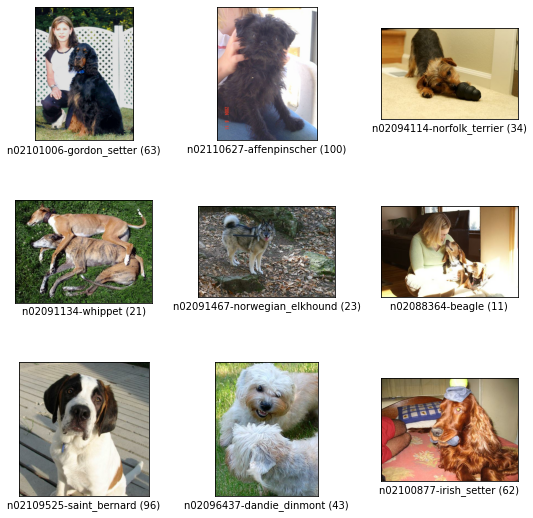

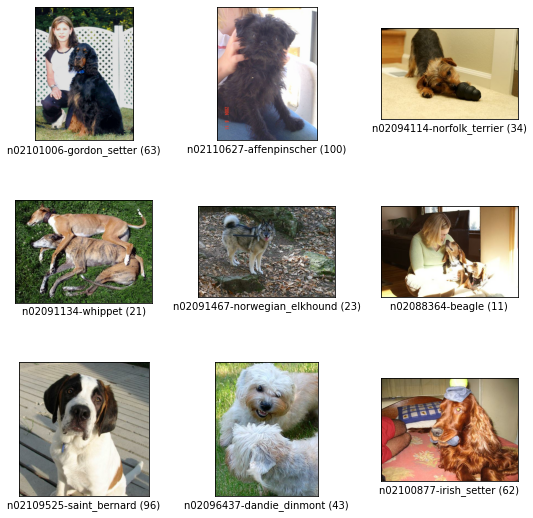

In [5]:
################# train 데이터 확인 ##################
tfds.show_examples(ds_train, ds_info)

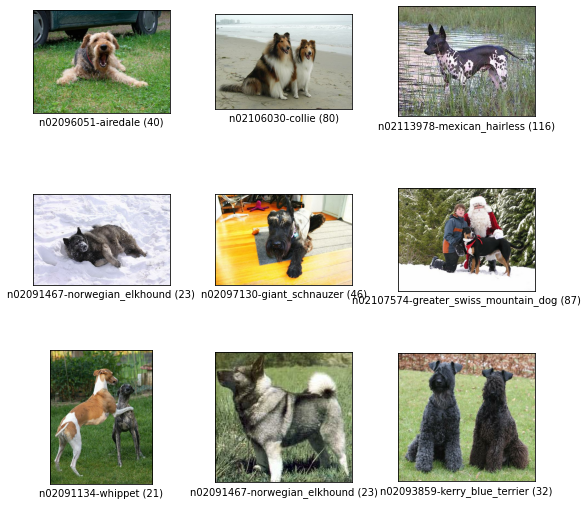

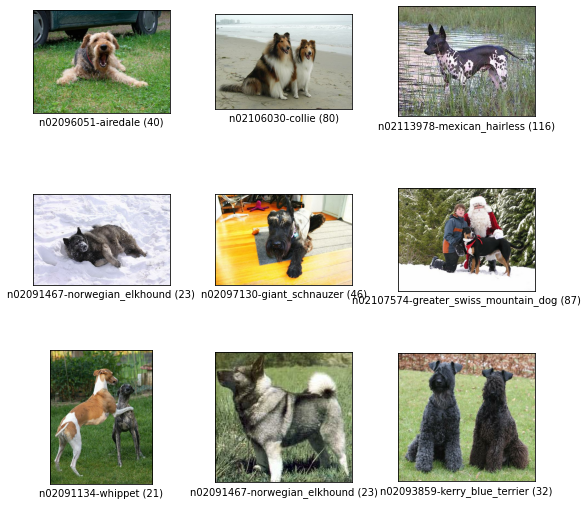

In [6]:
################# test 데이터 확인 ##################
tfds.show_examples(ds_test, ds_info)

## **2. Augmentation을 적용한 데이터셋 만들기**
---

### **2-1. Cutmix Augmentation 함수 정의**

In [32]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [33]:
##################### mix two images ###########################


def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [34]:
##################### mix two labels ###########################

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120, image_size=224):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size*image_size
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [35]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **2-2. Mixup Augmentation 함수 정의**

In [36]:
##################### function for mixup ############################ 
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [37]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **2-3. 데이터 전처리 함수 정의**

In [38]:
###################### 원핫인코딩 #########################

def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [39]:
###################### 정규화 & 사이즈 변경 #########################
## 0~1 범위로 normalize
## (224, 224) 사이즈로 resize

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


In [40]:
###################### augment #########################
## random_flip_left_right: 좌우 대칭
##  random_brightness: 명도 조절

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label



In [49]:
############## normalize & resize & augmentation & shuffle 적용 ###################


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### **2-4. augmentation 적용 데이터셋 생성**

In [50]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [51]:

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)


## **3. 모델 생성**
---
**기본: ResNet-50 베이스**
- res_no_aug: Augmentation 적용 x
- res_aug: 기본 Augmentation만 적용
- res_aug_cutmix: 기본 Augmentation + Cutmix 적용
- res_aug_mixup: 기본 Augmentation + Mixup 적용

In [52]:
num_classes = ds_info.features["label"].num_classes

### **3-1. Augmentation 적용x**

In [53]:
################ Augmentation 적용 x 모델 생성 #################

res_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
         weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


### **3-2. 기본 Augmentation 적용**

In [54]:
################ 기본 Augmentation 적용 #################

res_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### **3-3. 기본 Augmentation + Cutmix  적용**

In [55]:
############## 기본 Augmentation + Cutmix 적용 ##################

res_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### **3-3. 기본 Augmentation + mixup  적용**

In [56]:
############## 기본 Augmentation + mixup 적용 ##################

res_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## **4. 모델 훈련**
---

### **4-1. Augmentation 적용 x**


In [57]:
base_epoch = 20

In [ ]:
################ Augmentation 적용 x 모델 훈련 #################


res_no_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_res_no_aug = res_no_aug.fit(
    ds_train_no_aug, # augmentation x 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=base_epoch,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 109s 121ms/step - loss: 2.2176 - accuracy: 0.4471 - val_loss: 3.2129 - val_accuracy: 0.2245
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.6717 - accuracy: 0.8169 - val_loss: 1.0374 - val_accuracy: 0.6973
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2098 - accuracy: 0.9580 - val_loss: 0.9623 - val_accuracy: 0.7181
Epoch 4/20
750/750 [==============================] - 90s 119ms/step - loss: 0.0546 - accuracy: 0.9958 - val_loss: 0.9047 - val_accuracy: 0.7336
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0220 - accuracy: 0.9992 - val_loss: 0.9157 - val_accuracy: 0.7365
Epoch 6/20
750/750 [==============================] - 90s 119ms/step - loss: 0.0198 - accuracy: 0.9993 - val_loss: 0.9457 - val_accuracy: 0.7324
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0106 - accuracy: 0.9999 - val_loss: 0.9386 - val_accuracy: 0.

### **4-2. 기본 Augmentation 적용**

In [ ]:
################ 기본 Augmentation 적용한 모델 훈련 #################


res_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_res_aug = res_aug.fit(
    ds_train_aug, # 기본 augmentation 적용한 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=base_epoch,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 99s 120ms/step - loss: 2.2475 - accuracy: 0.4300 - val_loss: 2.7227 - val_accuracy: 0.3085
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 0.9461 - accuracy: 0.7299 - val_loss: 1.3576 - val_accuracy: 0.6145
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.5054 - accuracy: 0.8598 - val_loss: 1.2068 - val_accuracy: 0.6586
Epoch 4/20
750/750 [==============================] - 94s 125ms/step - loss: 0.2527 - accuracy: 0.9422 - val_loss: 1.1590 - val_accuracy: 0.6837
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1380 - accuracy: 0.9736 - val_loss: 0.9593 - val_accuracy: 0.7274
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0762 - accuracy: 0.9900 - val_loss: 1.0374 - val_accuracy: 0.7169
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0624 - accuracy: 0.9913 - val_loss: 1.0205 - val_accuracy: 0.7

### **4-3. 기본 Augmentation + Cutmix  적용**

In [ ]:
############## 기본 Augmentation + Cutmix 적용 모델 훈련 ##################


res_aug_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_res_aug_cutmix = res_aug_cutmix.fit(
    ds_train_aug_cutmix, # augmentation+cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=base_epoch,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 106s 127ms/step - loss: 3.9089 - accuracy: 0.1937 - val_loss: 2.9754 - val_accuracy: 0.2600
Epoch 2/20
750/750 [==============================] - 96s 128ms/step - loss: 3.0449 - accuracy: 0.4037 - val_loss: 1.5953 - val_accuracy: 0.5568
Epoch 3/20
750/750 [==============================] - 96s 128ms/step - loss: 2.7933 - accuracy: 0.4772 - val_loss: 1.3267 - val_accuracy: 0.6231
Epoch 4/20
750/750 [==============================] - 95s 126ms/step - loss: 2.5906 - accuracy: 0.5378 - val_loss: 1.2502 - val_accuracy: 0.6595
Epoch 5/20
750/750 [==============================] - 97s 129ms/step - loss: 2.4814 - accuracy: 0.5770 - val_loss: 1.2876 - val_accuracy: 0.6466
Epoch 6/20
750/750 [==============================] - 94s 126ms/step - loss: 2.3474 - accuracy: 0.6187 - val_loss: 1.2607 - val_accuracy: 0.6545
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 2.2631 - accuracy: 0.6440 - val_loss: 1.2868 - val_accuracy: 0.

### **4-4. 기본 Augmentation + Mixup  적용**

In [ ]:
############## 기본 Augmentation + mixup 적용 모델 훈련 ##################


res_aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_res_aug_mixup = res_aug_mixup.fit(
    ds_train_aug_mixup, # augmentation+mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=base_epoch,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 106s 128ms/step - loss: 3.7818 - accuracy: 0.2253 - val_loss: 3.5485 - val_accuracy: 0.1835
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 2.9573 - accuracy: 0.4447 - val_loss: 1.6555 - val_accuracy: 0.5543
Epoch 3/20
750/750 [==============================] - 96s 128ms/step - loss: 2.6954 - accuracy: 0.5353 - val_loss: 1.7594 - val_accuracy: 0.5287
Epoch 4/20
750/750 [==============================] - 96s 128ms/step - loss: 2.5196 - accuracy: 0.6021 - val_loss: 1.2924 - val_accuracy: 0.6300
Epoch 5/20
750/750 [==============================] - 96s 127ms/step - loss: 2.4105 - accuracy: 0.6432 - val_loss: 1.2571 - val_accuracy: 0.6460
Epoch 6/20
750/750 [==============================] - 97s 129ms/step - loss: 2.2977 - accuracy: 0.6901 - val_loss: 1.3609 - val_accuracy: 0.6240
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 2.2373 - accuracy: 0.7130 - val_loss: 1.1751 - val_accuracy: 0.

## **5. 훈련과정 시각화**
---

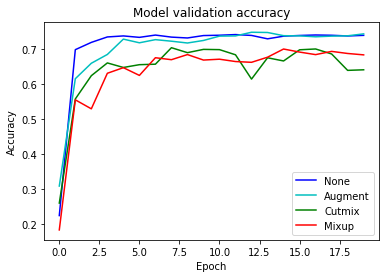

In [ ]:
############## accuracy ##################


plt.plot(history_res_no_aug.history['val_accuracy'], 'b')
plt.plot(history_res_aug.history['val_accuracy'], 'c')
plt.plot(history_res_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_res_aug_mixup.history['val_accuracy'], 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['None', 'Augment' , 'Cutmix', 'Mixup'], loc='lower right')
# plt.grid(True)
plt.show()

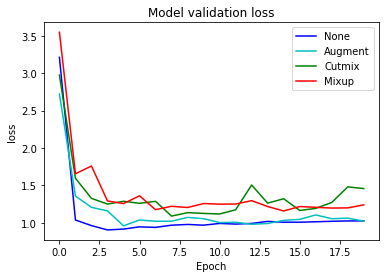

In [ ]:
############## loss ##################

plt.plot(history_res_no_aug.history['val_loss'], 'b')
plt.plot(history_res_aug.history['val_loss'], 'c')
plt.plot(history_res_aug_cutmix.history['val_loss'], 'g')
plt.plot(history_res_aug_mixup.history['val_loss'], 'r')

plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['None', 'Augment' , 'Cutmix', 'Mixup'], loc='upper right')
# plt.grid(True)
plt.show()